# MSE N = 8

# Orgnize all the input outputs simulations in one well organize file

In [1]:
import json

In [2]:
# Data INPUT to be written to a JSON file
n_inputs = 4
if n_inputs == 4:
    n_epochs = 20000
elif n_inputs == 8:
    n_epochs = 22000
elif n_inputs == 16:
    n_epochs = 25000

data = {
    "name_file": "traking_N8_MSE_sweep_imb",
    "n_inputs": n_inputs,
    "n_epochs": n_epochs,
    "date": "20240606",
    "train_type": "MSE",
    "seed": 37,
    "n_matrices": 1000,
    "n_repetitions": 5,
    "lr": 0.001,
    "n_bachup": 500,

    "data_out_type": "MSE",
    "rep_type": "min",
    "simulations": []
    }

if False:
    # Write JSON data to a file
    with open(data["name_file"]+"_"+data["date"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [3]:
# exapmple SIMULATION FORMAT
exampledata = {
    "simulations": [{
        "architecture": "NEUROPULS_Arct",
        "i_loss_const": 0.0,
        "imbalance_const": 0.05,
        "cross_talk_const": 0.05,
        "average": None,
        "dev_st": None
    }]
}

In [4]:
def append_output_simulation(data, name_arch, i_loss_const, imbalance_const, cross_talk_const, average=None, std_dev=None):
    dictionary = {
        "architecture": name_arch,
        "i_loss_const": i_loss_const,
        "imbalance_const": imbalance_const,
        "cross_talk_const": cross_talk_const,
        "average": average,
        "std_dev": std_dev
        }
    data["simulations"].append(dictionary)

# Write data except Flidyzian and ?????????

In [17]:
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# Compute MSE
def CMatrixMSELoss(target_matrix, predicted_matrix):
    mag_diff_sq = np.abs(predicted_matrix - target_matrix)**2
    loss = np.sum(mag_diff_sq) / np.size(target_matrix)
    return loss

# Extract targets and preditions from the simulation directory folder
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples

# Derive the MSE for all one entire simulation
def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

def derive_MSE_1sim(target_tuples, predit_tuples):
    loss = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            loss.extend([CMatrixMSELoss(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    labels = [t[0] for t in predit_tuples]
    loss_pd = pd.DataFrame({'label': labels, 'value': loss})
    return loss_pd

# Take best result MINIMUM value repetition
def models_repmin_mean_devstd(df, name_models):
    # Extracting the base label (e.g., 'LabelA', 'LabelB')
    df['label_no_rep'] = df['label'].apply(lambda x: x.split('_rep')[0])
    # Group with the base label and find min
    min_lastLoss_s = df.groupby('label_no_rep')['value'].min()

    mean_models= []
    std_dev_models =[]
    for name in name_models:
        # model_s take the all 1000 sim same model with the best repetition value
        model_s = min_lastLoss_s[min_lastLoss_s.index.str.contains(name)]
        mean_models.append(model_s.mean())
        std_dev_models.append(model_s.std())
    return mean_models, std_dev_models


directory_run = 'outdata/20240606_N8_onevaluewong_wrong_Fldzyan'
name_models = [
    'Clements_Arct', 'ClementsBell_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
    'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

ave_devstd_run = []

for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if not os.path.isfile(directory_path):
        target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
        mse_pd = derive_MSE_1sim(target_tuples, predit_tuples)
        mean_models, std_dev_models = models_repmin_mean_devstd(mse_pd, name_models)
        last_folder_name = os.path.basename(directory_path)
        for name, mean, std_dev in zip(name_models, mean_models, std_dev_models):
            new_data = [(last_folder_name, name, mean, std_dev)]
            ave_devstd_run.extend(new_data)

dt = np.dtype([
    ('simulation', 'U100'),
    ('model', 'U100'),
    ('average', 'f4'),
    ('std_dev', 'f4')
])
ave_devstd_run_nparray = np.array(ave_devstd_run, dtype=dt)
np.save(directory_run+'/run_ave_dev_save1.npy', ave_devstd_run_nparray)

In [6]:
# Extrat the iloss and imb from the simulation label
def extract_values(label):
    match = re.search(r'iloss([-+]?[0-9]*\.?[0-9]+)_imb([-+]?[0-9]*\.?[0-9]+)', label)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

In [7]:
directory_run = 'outdata/20240606_N8_onevaluewong_wrong_Fldzyan'
name_models = [
    'Clements_Arct', 'ClementsBell_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
    'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

# Read
with open(data["name_file"]+"_"+data["date"]+'.json', 'r') as file:
    data = json.load(file)

heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save1.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")
    

    for imb in np.arange(-0.45, 0.5, 0.05):
        rounded_imb = np.round(imb, 2)
        if not rounded_imb == 0:
            if "NEUROPULS" in name_model:
                cross_talk_const = abs(np.round(imb, 2))
            else:
                cross_talk_const = None
            append_output_simulation(
                data=data,
                name_arch=name_model,
                i_loss_const=0.0,
                imbalance_const=float(np.round(imb, 2)),
                cross_talk_const=cross_talk_const,
                average=float(ave_devstd_filtered_model_df[ave_devstd_filtered_model_df["imb"]==rounded_imb]["average"].values[0]),
                std_dev=float(ave_devstd_filtered_model_df[ave_devstd_filtered_model_df["imb"]==rounded_imb]["std_dev"].values[0]))


if False:
    # Write JSON data to a file
    with open(data["name_file"]+"_"+data["date"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [8]:
import os
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

# Compute MSE
def CMatrixMSELoss(target_matrix, predicted_matrix):
    mag_diff_sq = np.abs(predicted_matrix - target_matrix)**2
    loss = np.sum(mag_diff_sq) / np.size(target_matrix)
    return loss

# Extract targets and preditions from the simulation directory folder
def extract_targets_preditions_1sim(directory):
    target_tuples = []
    predit_tuples = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            target_tuples.extend([(label, array) for label, array in result_sim if 'target' in label])
            predit_tuples.extend([(label, array) for label, array in result_sim if 'prediction' in label])
    return target_tuples, predit_tuples

# Derive the MSE for all one entire simulation
def remove_until_underscore(s):     # from the end until the first '_'
    parts = s.split('_')
    result = '_'.join(parts[1:])
    return result

def derive_MSE_1sim(target_tuples, predit_tuples):
    loss = []
    for i in range(len(target_tuples)):
        if remove_until_underscore(target_tuples[i][0]) == remove_until_underscore(predit_tuples[i][0]):
            loss.extend([CMatrixMSELoss(target_tuples[i][1], predit_tuples[i][1])])
        else:
            print("Capo abbiamo un problema :(")
    labels = [t[0] for t in predit_tuples]
    loss_pd = pd.DataFrame({'label': labels, 'value': loss})
    return loss_pd

# Take best result MINIMUM value repetition
def models_repmin_mean_devstd(df, name_models):
    # Extracting the base label (e.g., 'LabelA', 'LabelB')
    df['label_no_rep'] = df['label'].apply(lambda x: x.split('_rep')[0])
    # Group with the base label and find min
    min_lastLoss_s = df.groupby('label_no_rep')['value'].min()

    mean_models= []
    std_dev_models =[]
    for name in name_models:
        # model_s take the all 1000 sim same model with the best repetition value
        model_s = min_lastLoss_s[min_lastLoss_s.index.str.contains(name)]
        mean_models.append(model_s.mean())
        std_dev_models.append(model_s.std())
    return mean_models, std_dev_models


directory_run = 'outdata/20240605_justFldzhyan'
name_models = ['Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct']

ave_devstd_run = []

for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if "n8" in directory_path:
        if not os.path.isfile(directory_path):
            target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
            mse_pd = derive_MSE_1sim(target_tuples, predit_tuples)
            mean_models, std_dev_models = models_repmin_mean_devstd(mse_pd, name_models)
            last_folder_name = os.path.basename(directory_path)
            for name, mean, std_dev in zip(name_models, mean_models, std_dev_models):
                new_data = [(last_folder_name, name, mean, std_dev)]
                ave_devstd_run.extend(new_data)

dt = np.dtype([
    ('simulation', 'U100'),
    ('model', 'U100'),
    ('average', 'f4'),
    ('std_dev', 'f4')
])
ave_devstd_run_nparray = np.array(ave_devstd_run, dtype=dt)
np.save(directory_run+'/run_ave_dev_save2.npy', ave_devstd_run_nparray)

In [9]:
directory_run = 'outdata/20240605_justFldzhyan'
name_models = ['Fldzhyan_Arct', 'FldzhyanBell_Arct',
               'FldzhyanBellHalf_Arct']

# Read
with open(data["name_file"]+"_"+data["date"]+'.json', 'r') as file:
    data = json.load(file)

heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save2.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")
    

    for imb in np.arange(-0.45, 0.5, 0.05):
        rounded_imb = np.round(imb, 2)
        if "NEUROPULS" in name_model:
            cross_talk_const = abs(np.round(imb, 2))
        else:
            cross_talk_const = None
        append_output_simulation(
            data=data,
            name_arch=name_model,
            i_loss_const=0.0,
            imbalance_const=float(np.round(imb, 2)),
            cross_talk_const=cross_talk_const,
            average=float(ave_devstd_filtered_model_df[ave_devstd_filtered_model_df["imb"]==rounded_imb]["average"].values[0]),
            std_dev=float(ave_devstd_filtered_model_df[ave_devstd_filtered_model_df["imb"]==rounded_imb]["std_dev"].values[0]))


if False:
    # Write JSON data to a file
    with open(data["name_file"]+"_"+data["date"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [20]:
directory_run = 'outdata/20240607_N8_00points'
name_models = [
    'Clements_Arct', 'ClementsBell_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
    'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

ave_devstd_run = []

for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if not os.path.isfile(directory_path):
        target_tuples, predit_tuples = extract_targets_preditions_1sim(directory_path)
        mse_pd = derive_MSE_1sim(target_tuples, predit_tuples)
        mean_models, std_dev_models = models_repmin_mean_devstd(mse_pd, name_models)
        last_folder_name = os.path.basename(directory_path)
        for name, mean, std_dev in zip(name_models, mean_models, std_dev_models):
            new_data = [(last_folder_name, name, mean, std_dev)]
            ave_devstd_run.extend(new_data)

dt = np.dtype([
    ('simulation', 'U100'),
    ('model', 'U100'),
    ('average', 'f4'),
    ('std_dev', 'f4')
])
ave_devstd_run_nparray = np.array(ave_devstd_run, dtype=dt)
np.save(directory_run+'/run_ave_dev_save_00points.npy', ave_devstd_run_nparray)

In [22]:
directory_run = 'outdata/20240607_N8_00points'
name_models = [
    'Clements_Arct', 'ClementsBell_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
    'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

# Read
with open(data["name_file"]+"_"+data["date"]+'.json', 'r') as file:
    data = json.load(file)

heatmap_data_xmodel = []
data_filterd = []
for name_model in name_models:
    ave_devstd_run = np.load(directory_run+'/run_ave_dev_save_00points.npy', allow_pickle=True)
    ave_devstd_df = pd.DataFrame(ave_devstd_run)
    ave_devstd_df[['iloss', 'imb']] = ave_devstd_df['simulation'].apply(lambda x: pd.Series(extract_values(x)))
    ave_devstd_filtered_model_df = ave_devstd_df[ave_devstd_df['model'] == name_model]
    ave_devstd_filtered_model_df = ave_devstd_filtered_model_df.sort_values("imb")

    rounded_imb = 0.0
    if "NEUROPULS" in name_model:
        cross_talk_const = rounded_imb
    else:
        cross_talk_const = None
    append_output_simulation(
        data=data,
        name_arch=name_model,
        i_loss_const=0.0,
        imbalance_const=rounded_imb,
        cross_talk_const=cross_talk_const,
        average=float(ave_devstd_filtered_model_df[ave_devstd_filtered_model_df["imb"]==rounded_imb]["average"].values[0]),
        std_dev=float(ave_devstd_filtered_model_df[ave_devstd_filtered_model_df["imb"]==rounded_imb]["std_dev"].values[0]))

if False:
    # Write JSON data to a file
    with open(data["name_file"]+"_"+data["date"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [23]:
# Sort the dictionary by architecture and imbalances

architecture_order = [
    'Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
    'FldzhyanBellHalf_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
    'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']

# Sorting function
def custom_sort_key(item):
    return (architecture_order.index(item['architecture']), item['imbalance_const'])

# Read
with open(data["name_file"]+"_"+data["date"]+'.json', 'r') as file:
    data = json.load(file)

simulations = data["simulations"]
# Sort the list
sorted_simulations = sorted(simulations, key=custom_sort_key)

data["simulations"] = sorted_simulations

if False:
    # Write JSON data to a file
    with open(data["name_file"]+"_"+data["date"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

# Grpath

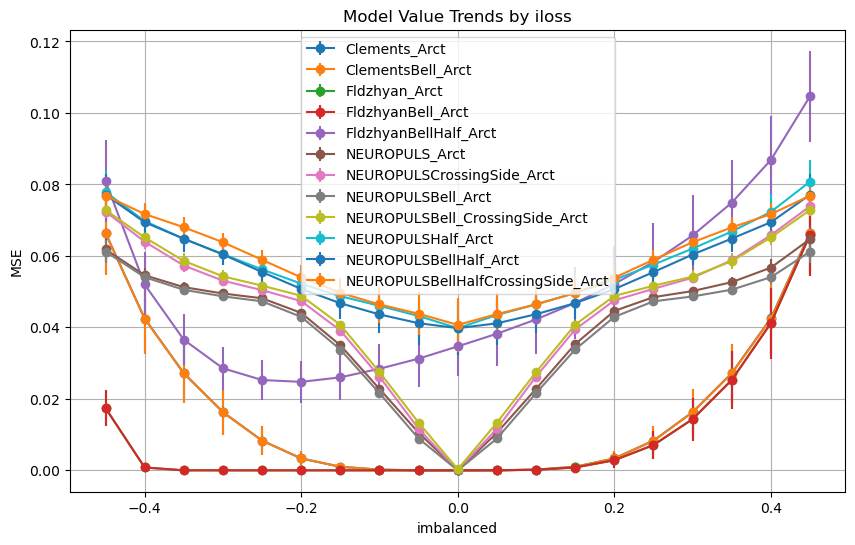

Clements_Arct average: 1.0715322851240217e-08
ClementsBell_Arct average: 5.275077441524445e-08
Fldzhyan_Arct average: 4.216484285279876e-06
FldzhyanBell_Arct average: 3.0369967589649605e-06
FldzhyanBellHalf_Arct average: 0.0346853993833065
NEUROPULS_Arct average: 1.6904203903322923e-06
NEUROPULSCrossingSide_Arct average: 1.5926709693303565e-06
NEUROPULSBell_Arct average: 5.25190330336045e-07
NEUROPULSBell_CrossingSide_Arct average: 0.0002959405246656388
NEUROPULSHalf_Arct average: 0.03977510705590248
NEUROPULSBellHalf_Arct average: 0.0397818386554718
NEUROPULSBellHalfCrossingSide_Arct average: 0.04069845750927925


In [29]:
# Create the grapth
# Download the file
with open(data["name_file"]+"_"+data["date"]+'.json', 'r') as file:
    data = json.load(file)

simulations = data["simulations"]

def filter_list_of_dicts(dict_list, name_arch):
    filtered_list = []
    for dictionary in dict_list:
        for value in dictionary.values():
            if value == name_arch:
                filtered_list.append(dictionary)
                break  # No need to check other values in the same dictionary
    return filtered_list


name_models = [
    'Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
    'FldzhyanBellHalf_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
    'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']
name_models_choise = [
    'Clements_Arct', 'ClementsBell_Arct', 'Fldzhyan_Arct', 'FldzhyanBell_Arct',
    'FldzhyanBellHalf_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct', 'NEUROPULSBell_Arct', 'NEUROPULSBell_CrossingSide_Arct',
    'NEUROPULSHalf_Arct', 'NEUROPULSBellHalf_Arct', 'NEUROPULSBellHalfCrossingSide_Arct']


plt.figure(figsize=(10, 6))
for name_arch in name_models_choise:
    filtered_list_disct = filter_list_of_dicts(simulations, name_arch)
    imbalances = [sim["imbalance_const"] for sim in filtered_list_disct]
    average = [sim["average"] for sim in filtered_list_disct]
    std_dev = [sim["std_dev"] for sim in filtered_list_disct]

    plt.errorbar(imbalances, average, yerr=std_dev,
                marker='o', label=name_arch)

plt.title('Model Value Trends by iloss')
plt.xlabel('imbalanced')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

for model in name_models:
    MSE_0 = [sim["average"] for sim in filter_list_of_dicts(simulations, model)][9]
    print(model+' average: '+str(MSE_0))